# Test run shift fit on HPC

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, statsmodels, seaborn

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings import *
from functions import *
from utils import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c


/apps/brussel/RL8/skylake/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
/apps/brussel/RL8/skylake/software/statsmodels/0.13.1-foss-2022a/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
from scipy import stats
import seaborn as sns

#import corner # installed in myenv - not used 
import statsmodels.api as sm 

sys.path.append('../dist_cov/dist_cov/')
import distributions as distributions
#import sample as sample
import utils as utils 

In [3]:
start_message()

flags: {'models': 'ISIMIP3a', 'experiment': 'obsclim', 'metric': 'WBGT', 'method': 'shift_fit', 'time_method': None, 'chunk_version': 0, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: ['GSWP3-W5E5', '20CRv3', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output
figdirs: /data/brussel/vo/000/bvo00

# Test for deployment on HPC job

In [5]:
os.path.join(scratchdirs,'output_apr24-9139513', 'WBGT', flags['models'], 'obsclim', datasets[0] )

'/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_apr24-9139513/WBGT/ISIMIP3a/obsclim/GSWP3-W5E5'

In [6]:
test = open_model_data(model=datasets[0], 
                    period='start-end', 
                    scenario1=flags['experiment'], 
                    scenario2=None, 
                    target_year=None, 
                    windowsize=None, 
                    chunk_version=flags['chunk_version'], #for job submit set to 2! 
                    variable=var,
                    startyear=2000,
                    endyear=2010,
                   )

opening data for wbgt
opening model data between 2000 and 2010


In [7]:
test

<xarray.DataArray 'wbgt' (time: 4018, lat: 360, lon: 720)>
dask.array<rechunk-merge, shape=(4018, 360, 720), dtype=float32, chunksize=(4018, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2010-12-31

In [4]:
#test_slice = test.sel(lat=slice(29,25), lon=slice(77,88)).compute()

In [9]:
test_slice

<xarray.DataArray 'wbgt' (time: 4018, lat: 8, lon: 22)>
array([[[16.689304 , 16.63147  , 16.805157 , ...,  9.252422 ,
         10.249233 , 11.302266 ],
        [16.84358  , 16.824575 , 16.738844 , ..., 10.78167  ,
         10.99244  , 11.0177555],
        [16.79257  , 17.0816   , 16.937904 , ..., 12.052876 ,
         11.292883 , 12.79905  ],
        ...,
        [17.705013 , 17.46891  , 17.312145 , ..., 17.689287 ,
         17.889496 , 18.06954  ],
        [17.657763 , 17.22867  , 17.148643 , ..., 17.721237 ,
         17.922321 , 18.252003 ],
        [18.2129   , 17.729746 , 17.410461 , ..., 17.741772 ,
         17.75696  , 18.463121 ]],

       [[17.691956 , 17.831701 , 18.231236 , ..., 10.002621 ,
         10.640749 , 11.7207575],
        [17.592445 , 17.77097  , 18.012802 , ..., 11.600751 ,
         11.303338 , 11.493603 ],
        [17.16006  , 17.687729 , 17.827166 , ..., 13.205894 ,
         11.948819 , 13.5786495],
...
        [20.10758  , 20.36043  , 20.784172 , ..., 18.901728 ,
         18.659084 , 19.00337  ],
        [20.586445 , 20.68204  , 20.889729 , ..., 19.684711 ,
         19.286453 , 19.51324  ],
        [21.190077 , 21.306684 , 21.364761 , ..., 20.60648  ,
         20.13681  , 20.061136 ]],

       [[16.050573 , 16.406002 , 16.354046 , ..., 11.742081 ,
         12.593866 , 13.990266 ],
        [16.238895 , 16.51562  , 17.02008  , ..., 12.519176 ,
         13.424061 , 13.453436 ],
        [16.636875 , 16.922789 , 17.305824 , ..., 15.619698 ,
         15.240772 , 15.135747 ],
        ...,
        [17.842653 , 17.715023 , 17.388603 , ..., 19.545565 ,
         18.968151 , 19.016129 ],
        [17.64433  , 17.58854  , 17.47146  , ..., 19.843357 ,
         19.071955 , 19.18022  ],
        [17.792301 , 17.985039 , 17.978888 , ..., 21.058931 ,
         20.786188 , 20.804655 ]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 77.25 77.75 78.25 78.75 ... 86.25 86.75 87.25 87.75
  * lat      (lat) float32 28.75 28.25 27.75 27.25 26.75 26.25 25.75 25.25
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2010-12-31

In [10]:
df_gmst_obs_annual = pd.read_csv(os.path.join('../../data/gmst/gmst-obs/forster2023/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]
gmst_smo = pd.DataFrame(apply_lowess(df_gmst_obs_annual, df_gmst_obs_annual.index, ntime=4))
gmst_smo

,gmst
year,
1850,-0.043519
1851,0.032947
1852,0.066480
1853,0.059362
1854,0.050768
...,...
2018,1.176428
2019,1.212890
2020,1.212564


In [11]:
params_test = norm_shift_fit_boot(test_slice, gmst_smo, shift_sigma=False, by_month=False, bootsize=3, alpha=0.05, seed=0, incl_mle=True)

In [12]:
params_test.sel(quantile='mle')

<xarray.DataArray 'fit_params' (lat: 8, lon: 22, params: 3)>
array([[[ 2.61198202e+01, -4.48642402e-01,  5.17037208e+00],
        [ 2.65274843e+01, -7.72405493e-01,  5.15869577e+00],
        [ 2.67484172e+01, -9.13042111e-01,  5.07633234e+00],
        [ 2.67329727e+01, -8.30639189e-01,  5.02623685e+00],
        [ 2.66686462e+01, -6.78315689e-01,  4.99054258e+00],
        [ 2.68216089e+01, -6.36687199e-01,  4.98809446e+00],
        [ 2.67163947e+01, -2.22294856e-01,  4.97994384e+00],
        [ 2.61933524e+01,  1.61293500e-01,  4.83455080e+00],
        [ 2.49552370e+01,  1.29190726e-01,  4.73885391e+00],
        [ 2.27129910e+01,  4.39361445e-01,  4.39620643e+00],
        [ 2.15143826e+01,  3.78587896e-01,  4.48317684e+00],
        [ 1.93393140e+01,  9.68323535e-01,  4.51672760e+00],
        [ 1.51958315e+01,  1.58313432e+00,  4.27906372e+00],
        [ 1.53164611e+01,  1.85542275e+00,  4.31548273e+00],
        [ 1.45878525e+01,  2.39780204e+00,  4.13862485e+00],
        [ 1.21691868e+01,  2.82652756e+00,  4.07519883e+00],
        [ 1.20383807e+01,  3.06863967e+00,  4.15045641e+00],
        [ 1.40984863e+01,  3.09254394e+00,  4.13035762e+00],
        [ 1.26259080e+01,  3.20849780e+00,  4.10312046e+00],
        [ 1.27549091e+01,  3.27480947e+00,  4.08334301e+00],
...
        [ 2.41148103e+01,  2.00639869e+00,  4.49598810e+00],
        [ 2.47316373e+01,  1.43572544e+00,  4.53328195e+00],
        [ 2.50355719e+01,  8.99141448e-01,  4.55240411e+00],
        [ 2.56864646e+01,  2.61478241e-01,  4.55777013e+00],
        [ 2.65189184e+01, -3.00934166e-01,  4.57007233e+00],
        [ 2.69219189e+01, -3.68041510e-01,  4.62523048e+00],
        [ 2.67049658e+01, -5.11486522e-02,  4.65272555e+00],
        [ 2.68570020e+01,  1.85553896e-02,  4.68678311e+00],
        [ 2.65954315e+01,  3.00378790e-01,  4.64758587e+00],
        [ 2.63998332e+01,  4.93500638e-01,  4.61439381e+00],
        [ 2.59124128e+01,  1.05735616e+00,  4.59281975e+00],
        [ 2.58700571e+01,  1.06452415e+00,  4.60099142e+00],
        [ 2.55660870e+01,  1.28235839e+00,  4.60451645e+00],
        [ 2.47940044e+01,  2.07121704e+00,  4.59303765e+00],
        [ 2.46401668e+01,  2.18506390e+00,  4.43520961e+00],
        [ 2.41719893e+01,  2.59578531e+00,  4.21170337e+00],
        [ 2.35421444e+01,  3.11354905e+00,  4.08804461e+00],
        [ 2.31965305e+01,  3.66438340e+00,  4.00343629e+00],
        [ 2.29096869e+01,  3.77437922e+00,  3.96844967e+00],
        [ 2.28459239e+01,  4.03580441e+00,  3.86612577e+00]]])
Coordinates:
  * lon       (lon) float32 77.25 77.75 78.25 78.75 ... 86.25 86.75 87.25 87.75
  * lat       (lat) float32 28.75 28.25 27.75 27.25 26.75 26.25 25.75 25.25
  * params    (params) <U5 'b0' 'b1' 'sigma'
    quantile  <U32 'mle'

In [13]:
params_test.sel(quantile=0.025)

<xarray.DataArray 'fit_params' (lat: 8, lon: 22, params: 3)>
array([[[26.69381779, -1.93533071,  5.13412359],
        [26.25648199, -2.50461309,  5.09697417],
        [26.02695227, -2.71017458,  5.01614467],
        [25.78833531, -2.75884992,  4.96584278],
        [25.87688495, -2.71755092,  4.92866389],
        [26.30414223, -2.58687045,  4.91401533],
        [26.67535598, -1.90099787,  4.91246799],
        [26.54613617, -1.08965767,  4.80095253],
        [25.35265347, -0.93989456,  4.70620239],
        [23.11626713, -0.26825334,  4.35016309],
        [21.82290098, -0.336713  ,  4.41776566],
        [19.5379003 ,  0.15893511,  4.44478942],
        [15.46524001,  1.02919182,  4.20718886],
        [15.65068441,  1.13228087,  4.23932536],
        [14.8497078 ,  1.52876757,  4.06584933],
        [12.37460612,  1.99900984,  3.97736896],
        [12.34756799,  2.37722921,  4.04342464],
        [14.33230101,  2.11385799,  4.0290186 ],
        [12.72855412,  2.19828916,  4.00353854],
        [12.90707982,  2.34459957,  4.0050193 ],
...
        [24.18545038,  0.42780124,  4.40833797],
        [24.62682796,  0.07372115,  4.45062116],
        [24.88415709, -0.24142266,  4.47918231],
        [25.37723768, -1.32604643,  4.49641124],
        [26.0915209 , -2.10378381,  4.50903147],
        [26.52114276, -2.03584157,  4.56128364],
        [26.37138703, -1.58885343,  4.58862042],
        [26.57058098, -1.27272334,  4.64494907],
        [26.31993117, -1.0855769 ,  4.63000448],
        [26.21951744, -0.79954092,  4.59941707],
        [25.78396456, -0.05836644,  4.5785138 ],
        [25.78114446, -0.25536667,  4.59214573],
        [25.50327962,  0.21379915,  4.58639432],
        [24.62093929,  0.93957234,  4.56301983],
        [24.43391092,  1.01928862,  4.39185669],
        [24.00723519,  1.63956813,  4.14361965],
        [23.53173454,  2.56697367,  4.00981518],
        [23.12557648,  2.83484321,  3.91840776],
        [22.88784699,  2.9894245 ,  3.87569249],
        [23.04137575,  3.57190528,  3.75046628]]])
Coordinates:
  * lon       (lon) float32 77.25 77.75 78.25 78.75 ... 86.25 86.75 87.25 87.75
  * lat       (lat) float32 28.75 28.25 27.75 27.25 26.75 26.25 25.75 25.25
  * params    (params) <U5 'b0' 'b1' 'sigma'
    quantile  <U32 '0.025'

In [1]:

from settings import *
from utils import * 

/apps/brussel/RL8/broadwell/software/statsmodels/0.13.1-foss-2022a/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
dataset=datasets[0]

make_outdir(dataset, makedirs=False) 

'/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_jun24/WBGT/ISIMIP3a/GSWP3-W5E5'

In [7]:
filesavename = get_filesavename(dataset, 
                                'obsclim',
                                None, 
                                ext=metric+'_params_shift_loc', 
                                data=None, 
                                keep_scenario=True,
                                startyear=start_pi, 
                                endyear=end_pi)

/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_apr24-9139513/WBGT/ISIMIP3a/obsclim/GSWP3-W5E5


In [8]:
filesavename

'gswp3-w5e5_obsclim_WBGT_params_shift_loc_1901_1931.nc'

In [5]:
dir1 = os.path.join(scratchdirs, 'output_apr24-9139513', 'WBGT', flags['models'],'obsclim', dataset )
dir1

'/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_apr24-9139513/WBGT/ISIMIP3a/obsclim/GSWP3-W5E5'

In [ ]:
glob.glob(os.path.join(dir1,'*.nc'))

In [7]:
var

'wbgt'

# Check output

In [27]:
## Longer time periods

filepath = glob.glob(os.path.join(outdirs, 'output_jun24-9469173/WBGT/ISIMIP3a/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_params_shift_*.nc'))[0]
print(filepath)
da = xr.open_dataarray(filepath)
da

# 9468033 : annual, global, loc only changes 
# 9468040 : monthly, global, loc only changes 
# 9469173 : monthly, global, loca and scale change

/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_jun24-9469173/WBGT/ISIMIP3a/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_params_shift_loc_1901_2019.nc


<xarray.DataArray 'fit_params' (month: 12, lat: 360, lon: 720, params: 4)>
[12441600 values with dtype=float64]
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma_b0' 'sigma_b1'

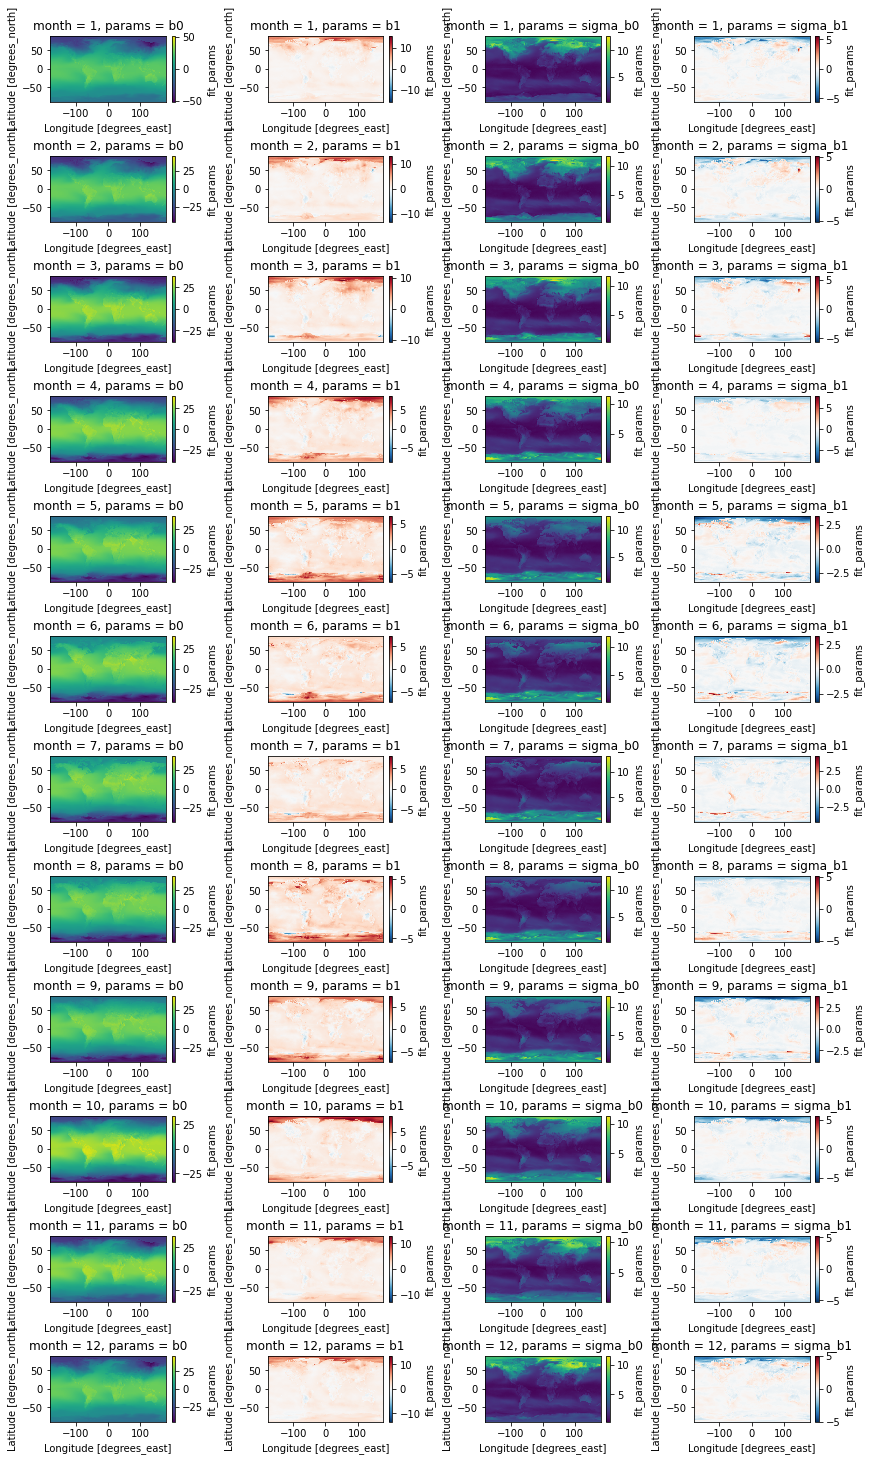

In [28]:
fig, axes = plt.subplots(12,4,figsize=(12,20), layout='constrained')

axes=axes.flatten()

j=0
#cmap='
for i in range(1,13):
    #print(j)
    da.sel(month=i,params='b0').plot(ax=axes[j],cmap='viridis')
    da.sel(month=i,params='b1').plot(ax=axes[j+1])
    da.sel(month=i,params='sigma_b0').plot(ax=axes[j+2])
    da.sel(month=i,params='sigma_b1').plot(ax=axes[j+3])
    j+=4

In [35]:

filepath = glob.glob(os.path.join(outdirs, 'output_jun24-9468033/WBGT/ISIMIP3a/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_params_shift_*.nc'))[0]
print(filepath)
da = xr.open_dataarray(filepath)
da

# 9468033 : annual, global, loc only changes 
# 9468040 : monthly, global, loc only changes 
# 9469173 : monthly, global, loca and scale change



/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_jun24-9468033/WBGT/ISIMIP3a/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_params_shift_loc_1901_2019.nc


<xarray.DataArray 'fit_params' (lat: 360, lon: 720, params: 3)>
[777600 values with dtype=float64]
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * params   (params) object 'b0' 'b1' 'sigma'

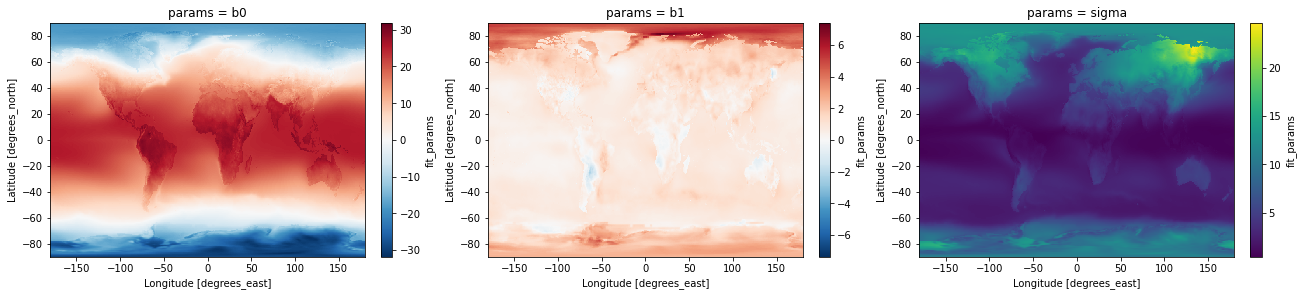

In [36]:
fig, axes = plt.subplots(1,3,figsize=(18,4), layout='constrained')

da.sel(params='b0').plot(ax=axes[0])
da.sel(params='b1').plot(ax=axes[1])
da.sel(params='sigma').plot(ax=axes[2])

In [37]:
filepath = glob.glob(os.path.join(outdirs, 'output_jun24-9468040/WBGT/ISIMIP3a/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_params_shift_*.nc'))[0]
print(filepath)
da = xr.open_dataarray(filepath)
da

# 9468033 : annual, global, loc only changes 
# 9468040 : monthly, global, loc only changes 
# 9469173 : monthly, global, loca and scale change


/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_jun24-9468040/WBGT/ISIMIP3a/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_params_shift_loc_1901_2019.nc


<xarray.DataArray 'fit_params' (month: 12, lat: 360, lon: 720, params: 3)>
[9331200 values with dtype=float64]
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'

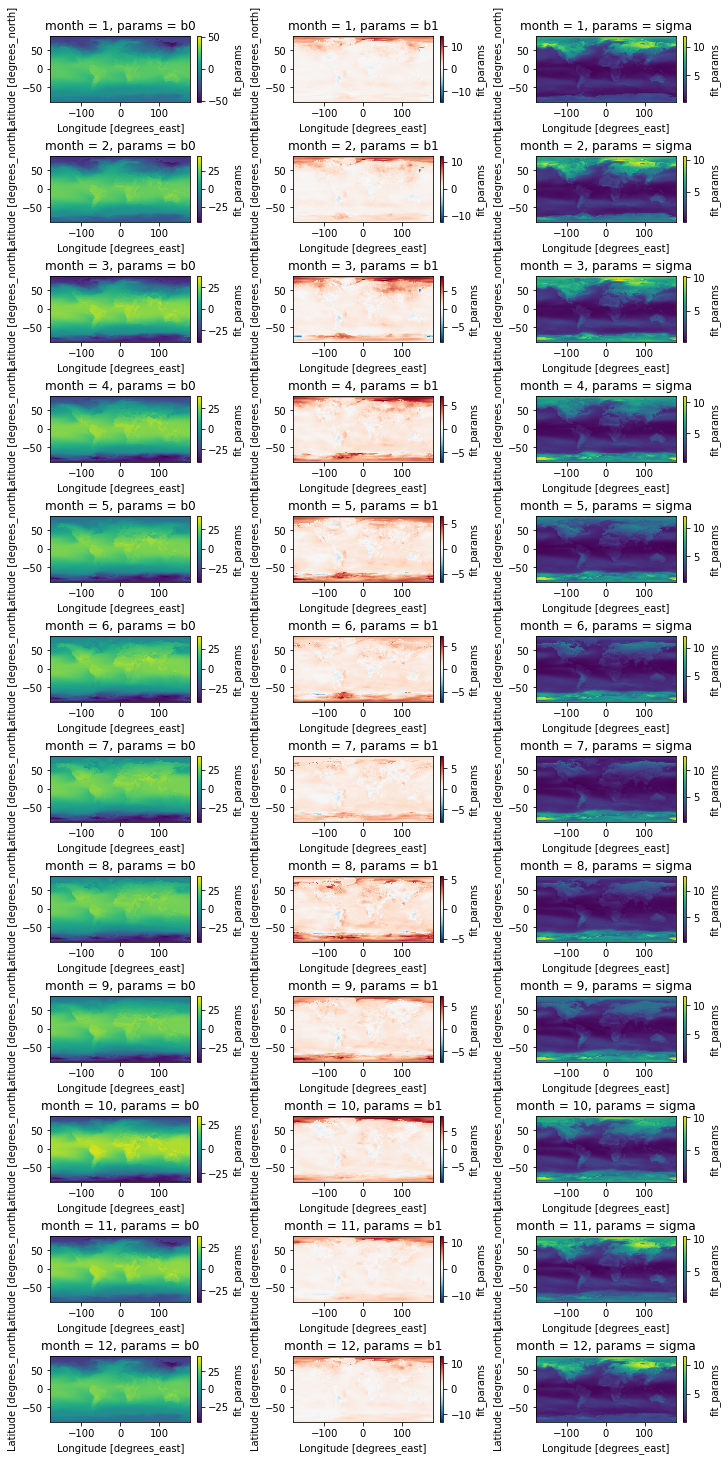

In [39]:
fig, axes = plt.subplots(12,3,figsize=(10,20), layout='constrained')

axes=axes.flatten()

j=0
#cmap='
for i in range(1,13):
    #print(j)
    da.sel(month=i,params='b0').plot(ax=axes[j],cmap='viridis')
    da.sel(month=i,params='b1').plot(ax=axes[j+1])
    da.sel(month=i,params='sigma').plot(ax=axes[j+2])
    j+=3